# Assignment 1

Implementing `Uniform`, `Poisson` and `Binomial` Distribution sampling using concepts of Inverse Discrete Transform and Accept-Reject Proposal technique

### Uniform Distribution

In [1]:
function uniform_custom(n=1, seed=time() % 100)
    a = 16807
    mod = 2^31 - 1
    sample = zeros(Float32, n)
    tmp = ((a * seed + 1) % mod)
    # not using the first value
    sample[1] = tmp / mod
    for i in 1:n
        tmp = (tmp * a + 1) % mod
        sample[i] = tmp / mod
    end
    return sample
end

uniform_custom (generic function with 3 methods)

### Poisson Distribution

In [17]:
function poisson_custom(n=1, λ=20, seed=time() % 100)
    result = zeros(n)
    uniform_sample = uniform_custom(n, seed)
    for i in 1:n
        k = 0
        p = exp(-λ)
        A = p
        while uniform_sample[i] >= A
            p = λ * p / (k + 1)
            A = A + p
            k = k + 1
        end
        result[i] = k
    end
    return result
end

poisson_custom (generic function with 4 methods)

In [3]:
function poisson_term_(base, λ, k, increase=true)
    #=
    ! Helper function
    base is the previous poisson term, increase tells whether to have the next term increased or decreased, k being the next term
    =#
    if increase
        p = base * λ / (k)
    else
        p = base * (k + 1) / λ
    end
    return p
end

poisson_term_ (generic function with 2 methods)

In [16]:
function poisson_fast(n=1, λ=20, seed=time() % 100)
    result = zeros(n)
    uniform_sample = uniform_custom(n, seed)
    for i in 1:n
        k = floor(λ)

        #= calculating lower bound 
        ! Find a better way to calculate this lower bound to make this much faster!
        =#
        p = exp(-λ)
        lower = 0
        for j in 0:k-1
            if j == 0
                lower = poisson_term(λ, 0)
                continue
            end
            p = poisson_term_(p, λ, j, true)
            lower += p
        end
        
        #= calculating upper bound =#
        p = poisson_term_(p, λ, k, true)
        upper = lower + p

        #= intializing helper variables =#
        increase_ = 1
        done = false

        #= checking if lower than the upper bound, then we have to decrease bounds =#
        if uniform_sample[i] < upper
            increase_ = -1
        end
        #= checking if without decreasing till yet, we are above lower limit =#
        if lower <= uniform_sample[i] && increase_ == -1
            result[i] = k
            done = true
        end
        while !done
            k += increase_
            if increase_ == -1
                upper = lower
                p = poisson_term_(p, λ, k, false)
                lower = upper - p
            elseif increase_ == 1
                lower = upper
                p = poisson_term_(p, λ, k, true)
                upper = lower + p
            end
            if (lower > upper)
                throw(DomainError)
            end
            # println(string(lower) * " " * string(upper) * " " * string(uniform_sample[i]))
            if lower <= uniform_sample[i] < upper
                result[i] = k
                done = true
            end
        end
    end
    return result
end

poisson_fast (generic function with 4 methods)

In [5]:
function sup_bin_poi(n, p, x)
    #=
    Helper function to calculate supremum for the pdf ratio of Binomial to Poisson
    =#
    prod = (1 - p)^(n - x) * exp(p * n)
    for i in 0:x-1
        prod *= (n - i) / n
    end
    return prod
end

sup_bin_poi (generic function with 1 method)

In [22]:
function binomial_custom(n_=1, n=100, p=0.4, seed=time() % 100)
    #=
    Using Poisson(n*p) as the proposal distribution
    =#
    result = zeros(n_)
    state_seed = 16807
    supremum = sup_bin_poi(n, p, n * p + 1) # 0.5 buffer value
    for i in 1:n_
        done = false
        tried = 0
        while !done
            tried += 1
            state_seed = (state_seed * seed + 1) % (2^31 - 1)
            ratio_check = uniform_custom(2, state_seed)[2]
            state_seed = (state_seed * seed + 1) % (2^31 - 1)
            propose = Int(poisson_custom(2, n * p, state_seed)[2])
            check_with = sup_bin_poi(n, p, propose) / (supremum)
            if ratio_check < check_with
                # println(string(ratio_check) * " " * string(check_with))
                done = true
                # println("Found at tries : " * string(tried))
                result[i] = propose
            else
                continue
            end
        end
    end
    return result
end

binomial_custom (generic function with 5 methods)

# Tests

In [12]:
using Statistics
using Plots: plot, histogram

## Uniform Distribution Sampling

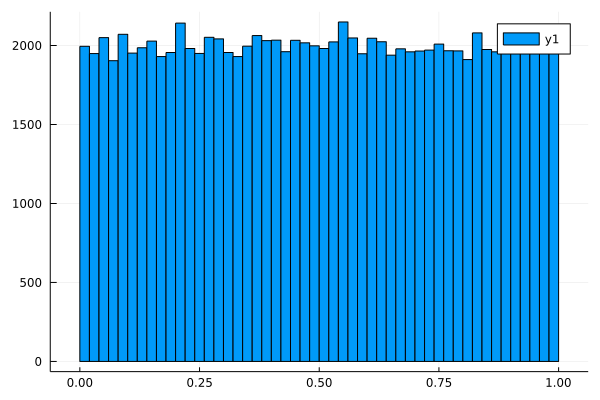

In [27]:
result = uniform_custom(100000)
display(plot(histogram(result)))

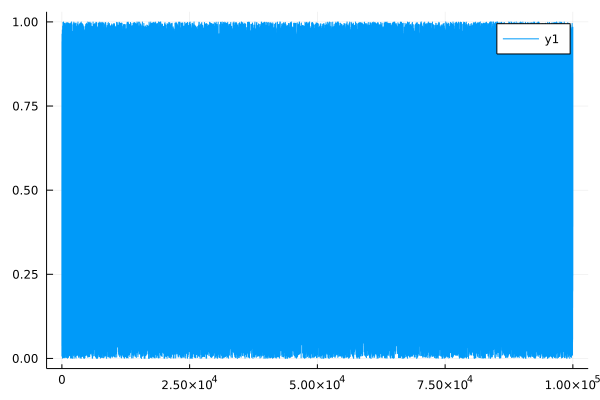

In [28]:
display(plot(result))

## Poisson Distribution Sampling

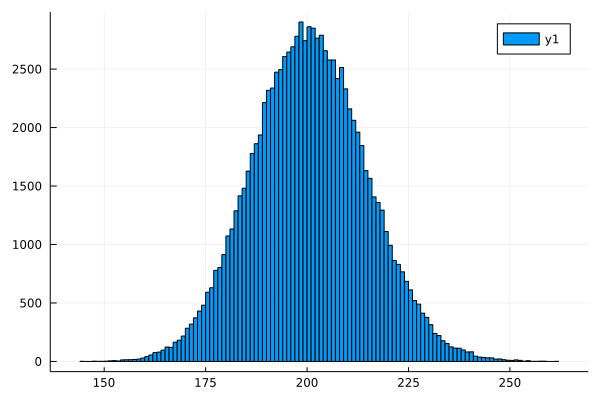

Sample mean : 200.1225
Sample variance : 198.50839883398834


In [25]:
result = poisson_custom(100000, 200)
# result = poisson_fast(10000, 200)
display(plot(histogram(result)))
println("Sample mean : "*string(mean(result)))
println("Sample variance : "*string(var(result)))

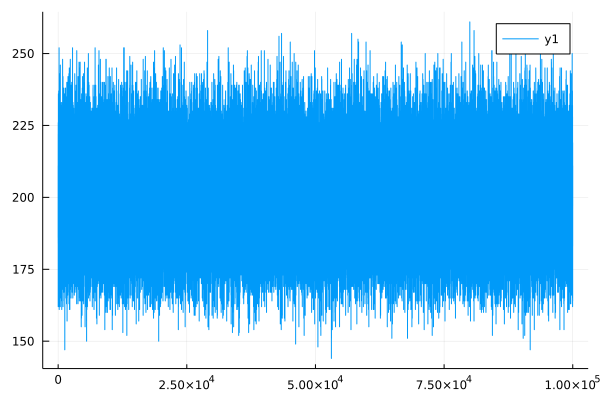

In [26]:
display(plot(result))

## Binomial Distribution Sampling

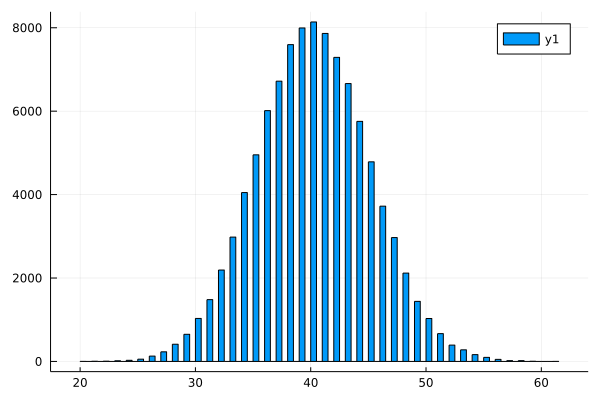

Sample mean : 39.96529
Sample variance : 24.115986375763768


In [24]:
result = binomial_custom(100000, 100, 0.4)
println("Sample mean : "*string(mean(result)))
println("Sample variance : "*string(var(result)))
display(plot(histogram(result)))

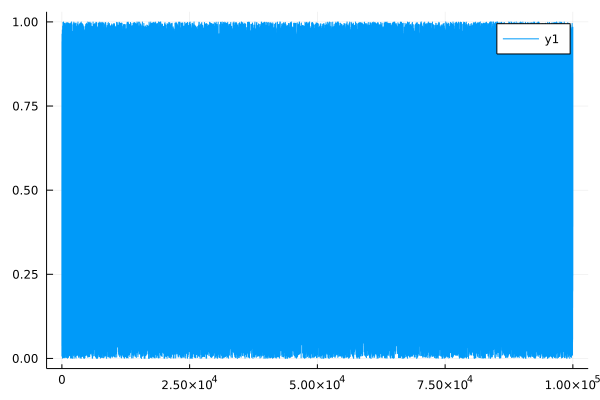

In [29]:
display(plot(result))